In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

100.0%


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100.0%


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100.0%


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100.0%

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



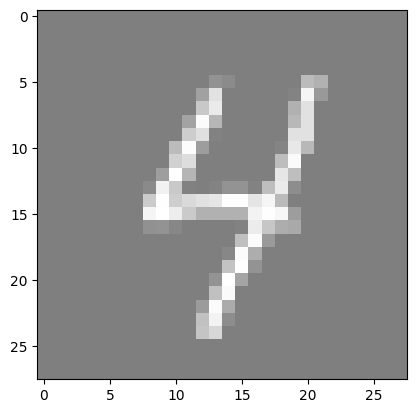

torch.Size([1, 28, 28])


In [17]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[0]))
print(images[0].shape)

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z    

In [4]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [18]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [19]:
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

In [20]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [21]:

def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [22]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

	 partial train loss (single batch): 69349.703125
	 partial train loss (single batch): 67770.921875
	 partial train loss (single batch): 66212.257812
	 partial train loss (single batch): 64812.175781
	 partial train loss (single batch): 63439.960938
	 partial train loss (single batch): 62402.230469
	 partial train loss (single batch): 61594.507812
	 partial train loss (single batch): 60874.156250
	 partial train loss (single batch): 60107.351562
	 partial train loss (single batch): 59285.128906
	 partial train loss (single batch): 58760.804688
	 partial train loss (single batch): 58302.906250
	 partial train loss (single batch): 57574.246094
	 partial train loss (single batch): 57489.312500
	 partial train loss (single batch): 56883.222656
	 partial train loss (single batch): 56394.421875
	 partial train loss (single batch): 56391.628906
	 partial train loss (single batch): 55608.609375
	 partial train loss (single batch): 55219.074219
	 partial train loss (single batch): 54908.437500


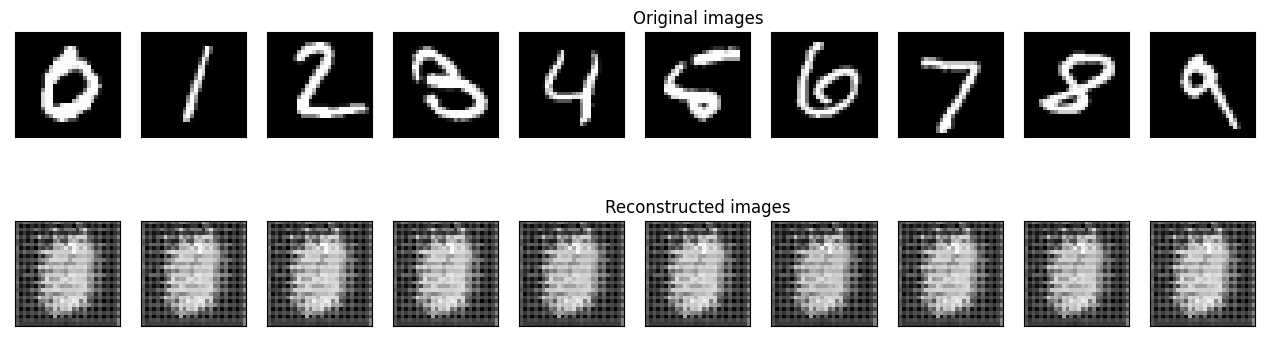

	 partial train loss (single batch): 20135.699219
	 partial train loss (single batch): 20077.363281
	 partial train loss (single batch): 19895.265625
	 partial train loss (single batch): 19671.107422
	 partial train loss (single batch): 19574.591797
	 partial train loss (single batch): 19582.369141
	 partial train loss (single batch): 19675.091797
	 partial train loss (single batch): 19556.099609
	 partial train loss (single batch): 19401.281250
	 partial train loss (single batch): 19699.048828
	 partial train loss (single batch): 19190.521484
	 partial train loss (single batch): 19230.585938
	 partial train loss (single batch): 19102.367188
	 partial train loss (single batch): 18906.572266
	 partial train loss (single batch): 19210.816406
	 partial train loss (single batch): 19083.888672
	 partial train loss (single batch): 18825.341797
	 partial train loss (single batch): 18995.291016
	 partial train loss (single batch): 18979.044922
	 partial train loss (single batch): 18695.812500


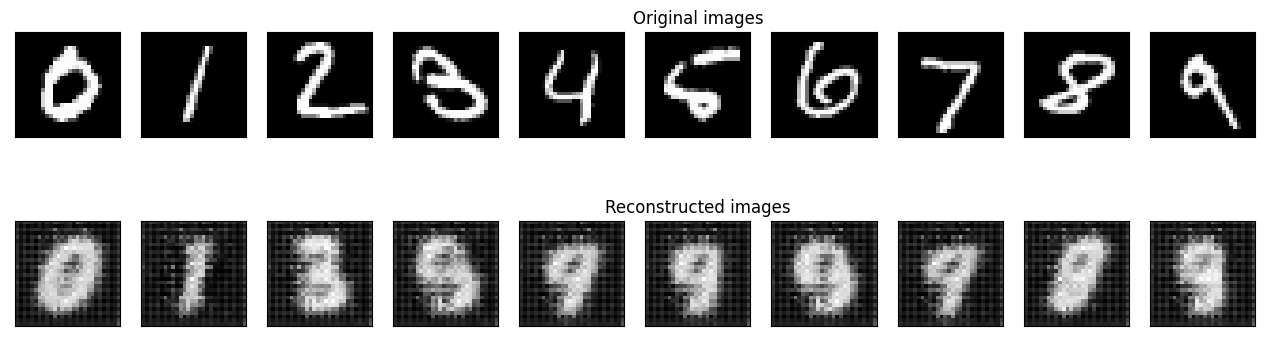

	 partial train loss (single batch): 13538.376953
	 partial train loss (single batch): 13388.685547
	 partial train loss (single batch): 13313.491211
	 partial train loss (single batch): 13210.182617
	 partial train loss (single batch): 13185.281250
	 partial train loss (single batch): 13235.383789
	 partial train loss (single batch): 13310.071289
	 partial train loss (single batch): 13277.167969
	 partial train loss (single batch): 12998.230469
	 partial train loss (single batch): 13413.069336
	 partial train loss (single batch): 13106.886719
	 partial train loss (single batch): 13133.802734
	 partial train loss (single batch): 13272.058594
	 partial train loss (single batch): 12993.947266
	 partial train loss (single batch): 13388.036133
	 partial train loss (single batch): 13070.398438
	 partial train loss (single batch): 12819.634766
	 partial train loss (single batch): 13146.167969
	 partial train loss (single batch): 13096.067383
	 partial train loss (single batch): 12905.302734


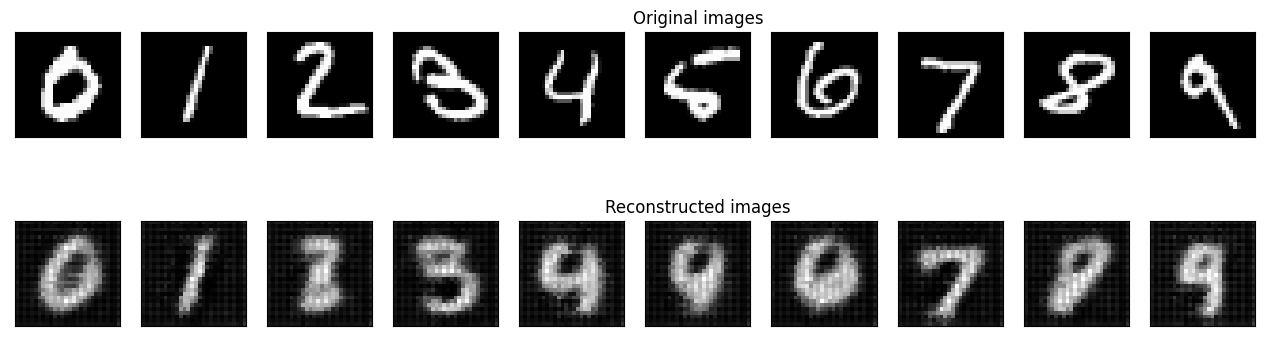

	 partial train loss (single batch): 11141.219727
	 partial train loss (single batch): 10951.332031
	 partial train loss (single batch): 10787.194336
	 partial train loss (single batch): 10850.068359
	 partial train loss (single batch): 10787.824219
	 partial train loss (single batch): 10877.196289
	 partial train loss (single batch): 11029.495117
	 partial train loss (single batch): 10929.554688
	 partial train loss (single batch): 10704.884766
	 partial train loss (single batch): 11041.786133
	 partial train loss (single batch): 10889.205078
	 partial train loss (single batch): 10906.012695
	 partial train loss (single batch): 11090.906250
	 partial train loss (single batch): 10873.500000
	 partial train loss (single batch): 11155.120117
	 partial train loss (single batch): 10767.317383
	 partial train loss (single batch): 10740.171875
	 partial train loss (single batch): 10716.280273
	 partial train loss (single batch): 10872.195312
	 partial train loss (single batch): 10784.559570


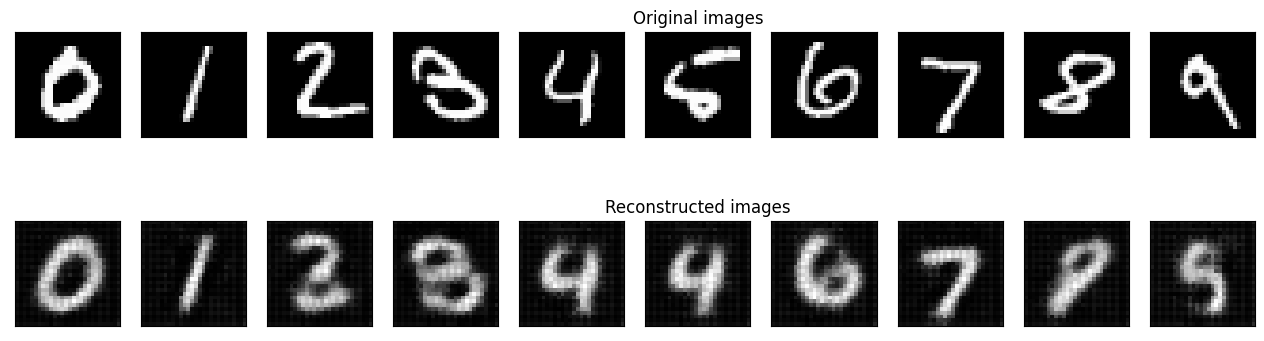

	 partial train loss (single batch): 9914.044922
	 partial train loss (single batch): 9802.473633
	 partial train loss (single batch): 9555.127930
	 partial train loss (single batch): 9797.719727
	 partial train loss (single batch): 9664.959961
	 partial train loss (single batch): 9790.554688
	 partial train loss (single batch): 9960.717773
	 partial train loss (single batch): 9890.331055
	 partial train loss (single batch): 9591.725586
	 partial train loss (single batch): 9879.050781
	 partial train loss (single batch): 9959.583984
	 partial train loss (single batch): 9829.111328
	 partial train loss (single batch): 9995.210938
	 partial train loss (single batch): 10012.751953
	 partial train loss (single batch): 10079.530273
	 partial train loss (single batch): 9719.872070
	 partial train loss (single batch): 9717.117188
	 partial train loss (single batch): 9687.221680
	 partial train loss (single batch): 9836.263672
	 partial train loss (single batch): 9744.092773
	 partial train lo

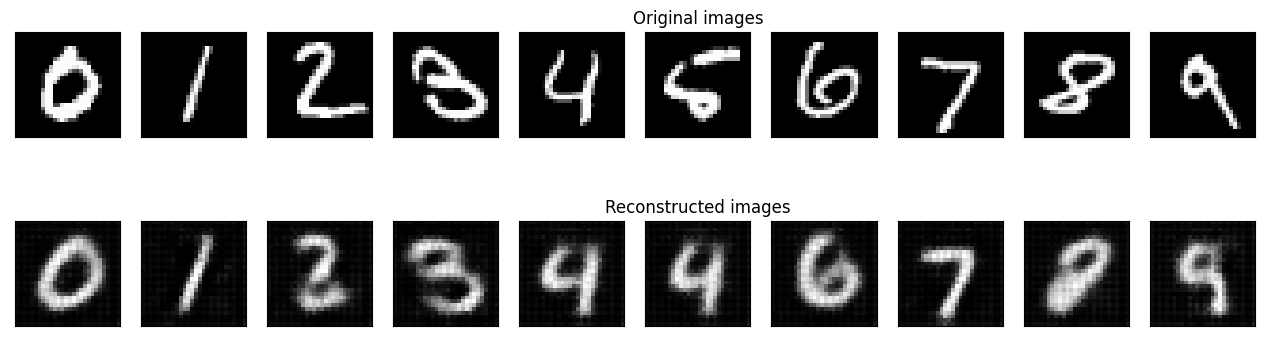

	 partial train loss (single batch): 9509.643555
	 partial train loss (single batch): 9348.510742
	 partial train loss (single batch): 9155.892578
	 partial train loss (single batch): 9222.981445
	 partial train loss (single batch): 9349.398438
	 partial train loss (single batch): 9344.087891
	 partial train loss (single batch): 9511.982422
	 partial train loss (single batch): 9453.367188
	 partial train loss (single batch): 9135.578125
	 partial train loss (single batch): 9423.337891
	 partial train loss (single batch): 9500.388672
	 partial train loss (single batch): 9423.540039
	 partial train loss (single batch): 9593.025391
	 partial train loss (single batch): 9576.251953
	 partial train loss (single batch): 9642.583008
	 partial train loss (single batch): 9310.509766
	 partial train loss (single batch): 9282.401367
	 partial train loss (single batch): 9148.952148
	 partial train loss (single batch): 9524.621094
	 partial train loss (single batch): 9335.384766
	 partial train loss

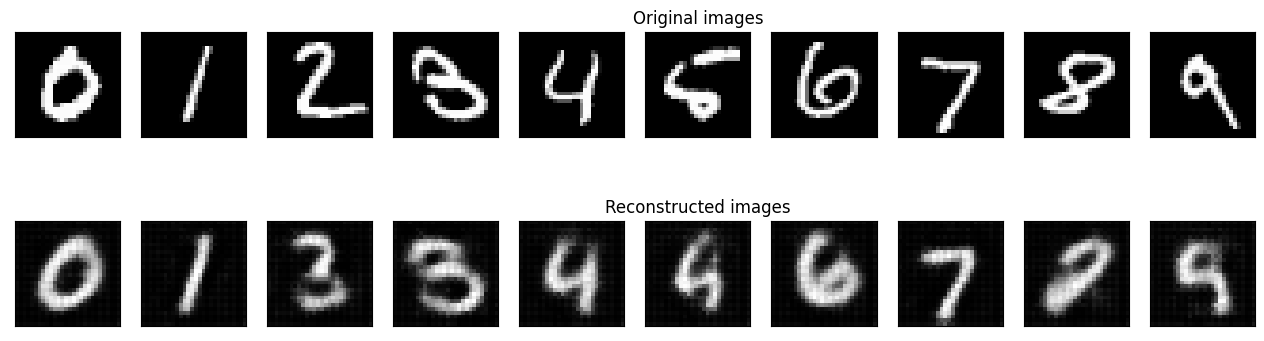

	 partial train loss (single batch): 9226.275391
	 partial train loss (single batch): 9133.660156
	 partial train loss (single batch): 8870.581055
	 partial train loss (single batch): 8894.380859
	 partial train loss (single batch): 9062.089844
	 partial train loss (single batch): 9137.824219
	 partial train loss (single batch): 9198.493164
	 partial train loss (single batch): 9284.974609
	 partial train loss (single batch): 8875.341797
	 partial train loss (single batch): 9131.632812
	 partial train loss (single batch): 9308.549805
	 partial train loss (single batch): 9201.533203
	 partial train loss (single batch): 9407.083984
	 partial train loss (single batch): 9384.925781
	 partial train loss (single batch): 9353.982422
	 partial train loss (single batch): 9012.732422
	 partial train loss (single batch): 9020.785156
	 partial train loss (single batch): 8830.197266
	 partial train loss (single batch): 9246.324219
	 partial train loss (single batch): 9025.686523
	 partial train loss

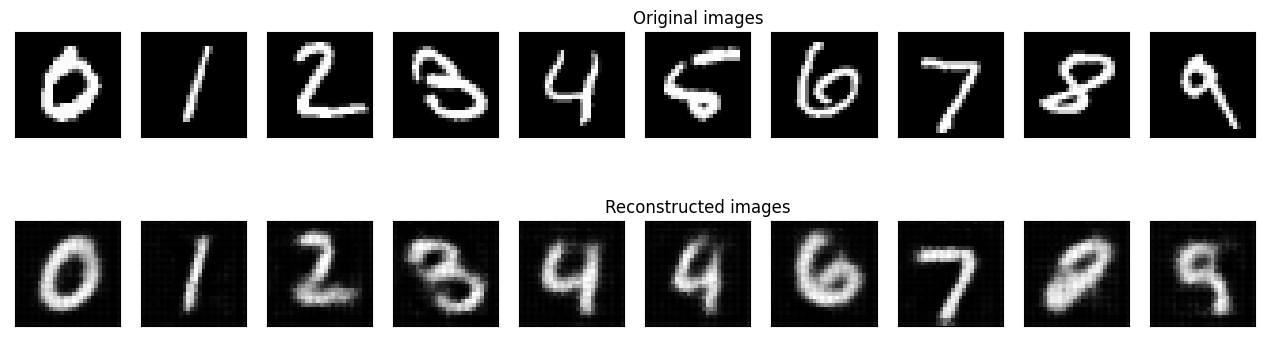

	 partial train loss (single batch): 9115.463867
	 partial train loss (single batch): 9010.830078
	 partial train loss (single batch): 8742.312500
	 partial train loss (single batch): 8743.457031
	 partial train loss (single batch): 8899.810547
	 partial train loss (single batch): 8961.232422
	 partial train loss (single batch): 9081.925781
	 partial train loss (single batch): 9141.539062
	 partial train loss (single batch): 8804.363281
	 partial train loss (single batch): 9022.146484
	 partial train loss (single batch): 9169.670898
	 partial train loss (single batch): 9072.059570
	 partial train loss (single batch): 9285.133789
	 partial train loss (single batch): 9179.507812
	 partial train loss (single batch): 9206.898438
	 partial train loss (single batch): 8857.498047
	 partial train loss (single batch): 8952.623047
	 partial train loss (single batch): 8722.560547
	 partial train loss (single batch): 9090.814453
	 partial train loss (single batch): 8947.660156
	 partial train loss

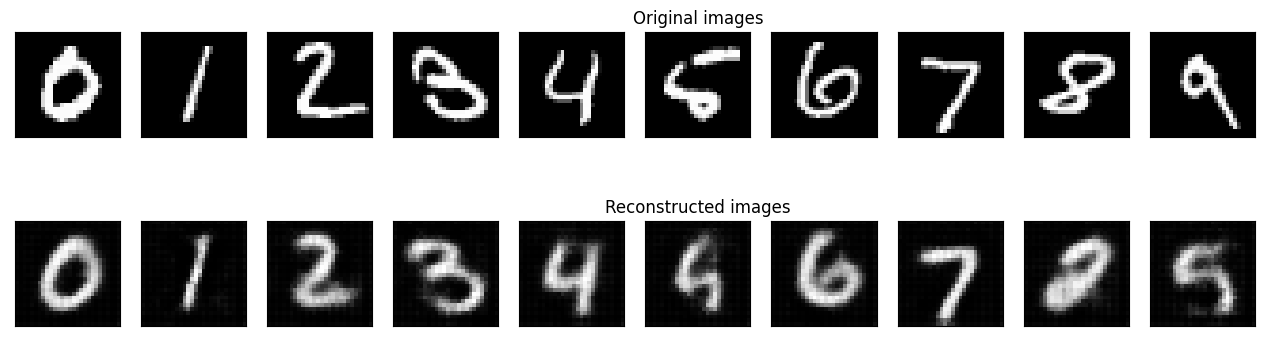

	 partial train loss (single batch): 8883.369141
	 partial train loss (single batch): 8856.554688
	 partial train loss (single batch): 8625.674805
	 partial train loss (single batch): 8595.266602
	 partial train loss (single batch): 8764.978516
	 partial train loss (single batch): 8798.166016
	 partial train loss (single batch): 8959.318359
	 partial train loss (single batch): 9001.951172
	 partial train loss (single batch): 8542.875977
	 partial train loss (single batch): 8831.905273
	 partial train loss (single batch): 9034.375977
	 partial train loss (single batch): 8894.982422
	 partial train loss (single batch): 9016.945312
	 partial train loss (single batch): 9085.783203
	 partial train loss (single batch): 9046.828125
	 partial train loss (single batch): 8670.410156
	 partial train loss (single batch): 8696.372070
	 partial train loss (single batch): 8623.994141
	 partial train loss (single batch): 8988.649414
	 partial train loss (single batch): 8831.268555
	 partial train loss

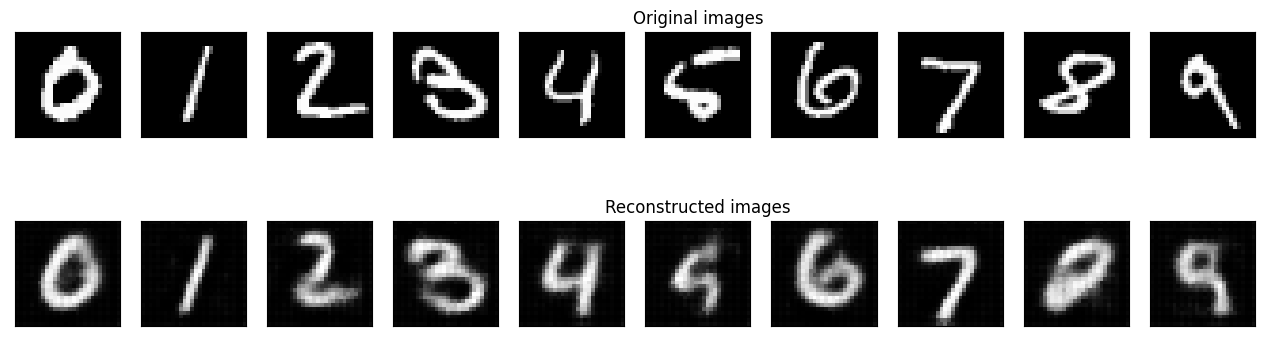

	 partial train loss (single batch): 8856.153320
	 partial train loss (single batch): 8795.466797
	 partial train loss (single batch): 8543.580078
	 partial train loss (single batch): 8536.964844
	 partial train loss (single batch): 8658.373047
	 partial train loss (single batch): 8722.170898
	 partial train loss (single batch): 8938.593750
	 partial train loss (single batch): 8918.626953
	 partial train loss (single batch): 8579.869141
	 partial train loss (single batch): 8730.857422
	 partial train loss (single batch): 8907.611328
	 partial train loss (single batch): 8883.253906
	 partial train loss (single batch): 8982.139648
	 partial train loss (single batch): 8968.201172
	 partial train loss (single batch): 9041.666016
	 partial train loss (single batch): 8678.191406
	 partial train loss (single batch): 8573.544922
	 partial train loss (single batch): 8488.964844
	 partial train loss (single batch): 8888.516602
	 partial train loss (single batch): 8719.736328
	 partial train loss

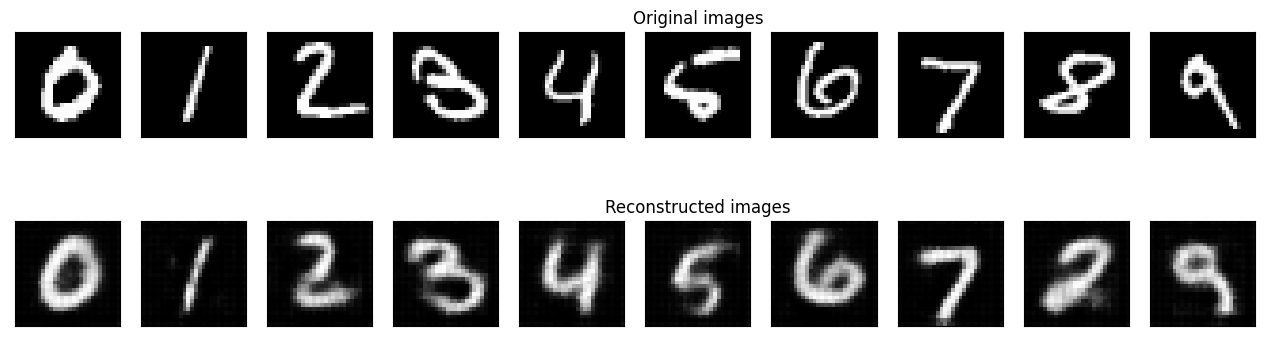

In [23]:
num_epochs = 10

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)